### Import Dependencies


In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd
from scipy import optimize
import matplotlib.pyplot as plt
import cv2
import glob
import pickle 
import re
from mpl_toolkits.mplot3d import Axes3D

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split('(\d+)', text) ]



### Loading Intrinsic & Extrinsic Camera Parameters

Ordered by (data number, webcam number, (sample number))

In [2]:
## Extrinsic

cal_fp = 'dataset/calibrations'

Rmats = np.zeros((21,4,3,3))
tvecs = np.zeros((21,4,3))

for i in range(21):
    for j in range(4):
        temp = '{}/data_{}/webcam_{}'.format(cal_fp, i+1, j+1)
        rvec = pickle.load(open('{}/rvec.pkl'.format(temp), 'rb'),
                           encoding='latin1')
        Rmats[i,j], _ = cv2.Rodrigues(rvec)
        
        tvecs[i, j] = pickle.load(open('{}/tvec.pkl'.format(temp), 'rb'),
                                 encoding='latin1').ravel()
        
## Intrinsic
A = np.array([[614.878, 0, 313.219],
             [0, 615.479, 231.288],
             [0, 0, 1]])

distcoeffs = np.array([0.092701, -0.175877, -0.0035687, -0.00302299, 0])

### Loading joint coordinates

In [3]:
data_fp = 'dataset/annotated_frames'
aug_fp = 'dataset/augmented_samples'

all_points2d = []
all_points3d = []
image_fps = []
aug_image_fps = []

for i in range(21):
    print('Loading Data {}/21...'.format(i+1))
    fps_3d = sorted(glob.glob('{}/data_{}/*_joints.txt'.format(data_fp, i+1)),
                   key=lambda x: natural_keys(x)[3])

    for j, fp in enumerate(fps_3d):
        df3d = pd.read_csv(fp, sep=' ', header=None)
        pos3d = df3d.as_matrix([1,2,3])[:-1]
        
        ones = np.ones((pos3d.shape[0],1))
        pos3d_ones = np.hstack((pos3d, ones))
        
        for k in range(4): # Webcam Number
            
            points2d, _ = cv2.projectPoints(
                pos3d, Rmats[i,k], tvecs[i,k], A, distcoeffs)
            T = np.hstack((Rmats[i,k], tvecs[i,k][:, np.newaxis]))
            points3d = np.matmul(pos3d_ones, T.T)  

            image_fps.append('{}/data_{}/{}_webcam_{}.jpg'.format(
                data_fp, i+1, j, k+1))
            aug_image_fps.append('{}/data_{}/{}_webcam_{}.jpg'.format(
                aug_fp, i+1, j, k+1))
            all_points2d.append(np.squeeze(points2d,axis=1))
            all_points3d.append(points3d)

            


Loading Data 1/21...
Loading Data 2/21...
Loading Data 3/21...
Loading Data 4/21...
Loading Data 5/21...
Loading Data 6/21...
Loading Data 7/21...
Loading Data 8/21...
Loading Data 9/21...
Loading Data 10/21...
Loading Data 11/21...
Loading Data 12/21...
Loading Data 13/21...
Loading Data 14/21...
Loading Data 15/21...
Loading Data 16/21...
Loading Data 17/21...
Loading Data 18/21...
Loading Data 19/21...
Loading Data 20/21...
Loading Data 21/21...


### Sample Hands

dataset/augmented_samples/data_8/53_webcam_3.jpg


<IPython.core.display.Javascript object>


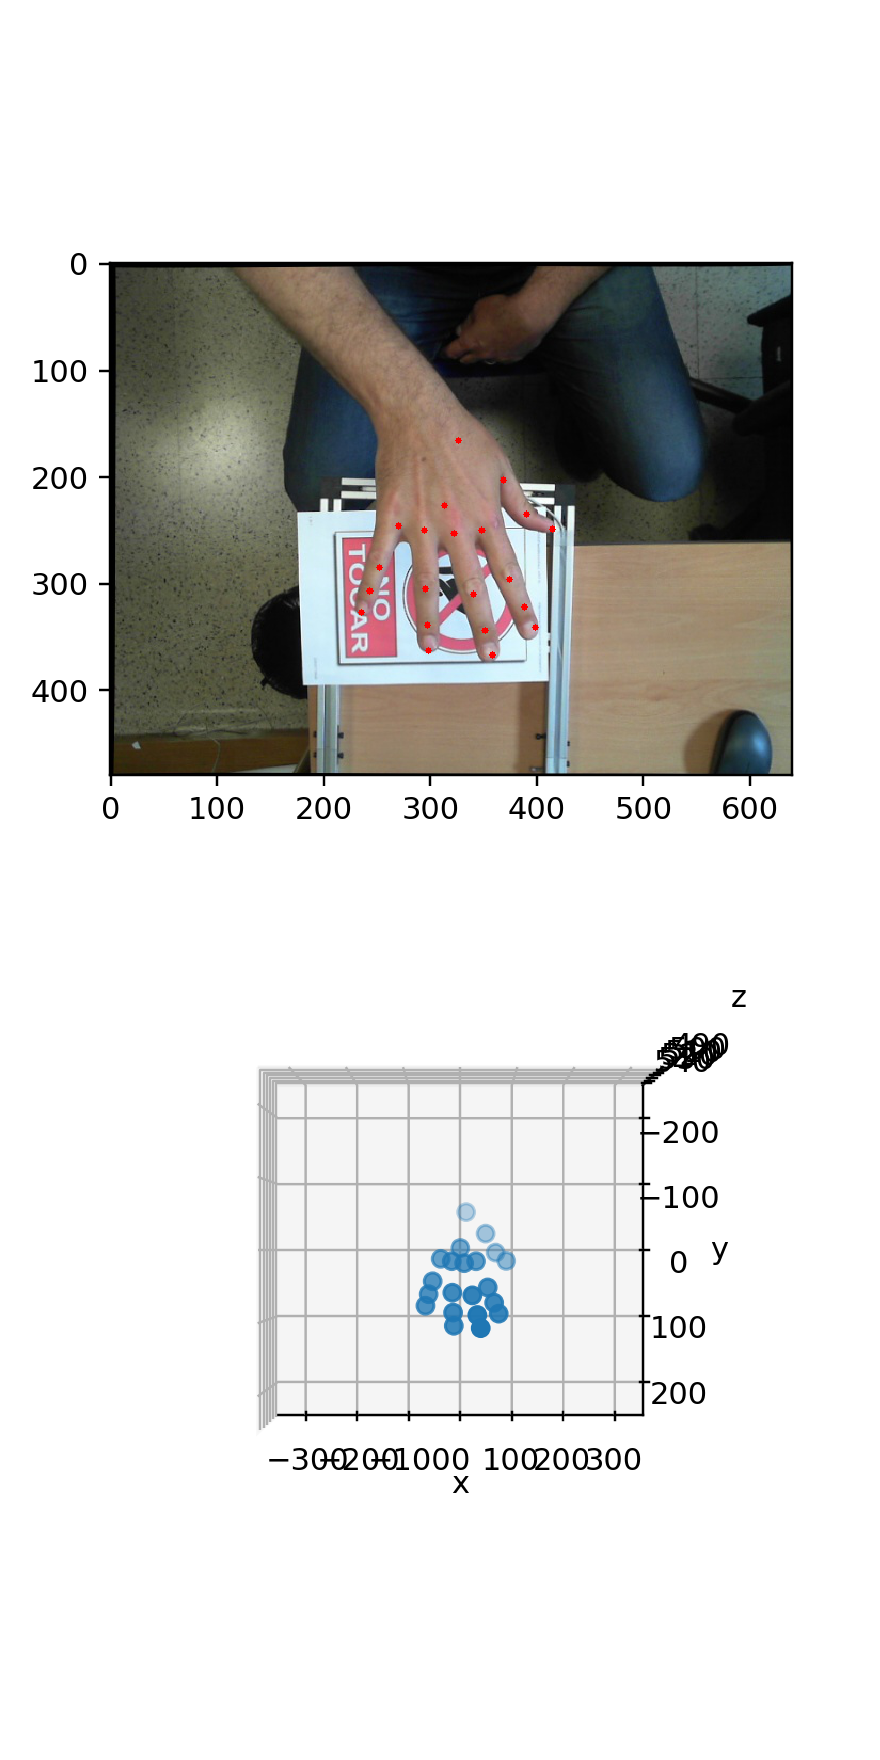

In [8]:
#aug data 12 and 13 are missing
c = np.random.randint(len(all_points3d))
img = cv2.imread(image_fps[c])
print(aug_image_fps[c])
points = all_points2d[c].astype(int)
points3d = all_points3d[c]

for point in points:
    cv2.circle(img, (point[0], point[1]), 3, (0,0,255), -1)

img = img[:, :, ::-1] # convert to rgb

fig = plt.figure(figsize=plt.figaspect(2.))
ax = fig.add_subplot(2,1,1)
ax.imshow(img)
ax = fig.add_subplot(2,1,2, projection='3d')
ax.set_xlim(-340,340)
ax.set_ylim(-240,240)
ax.view_init(-90,-90)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.scatter(points3d[:,0], points3d[:,1], points3d[:,2], s=30)
plt.show()
